In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from einops import rearrange
from sklearn.metrics import confusion_matrix, classification_report

# 中文显示配置（兼容英文环境）
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans', 'Arial']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

# 设备配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备：{device}")
if device.type == 'cuda':
    print(f"GPU型号：{torch.cuda.get_device_name(0)}")

# ========== 核心参数配置 ==========
PKL_3D_DIR = '/root/second/3D'  # 你的3D骨架数据路径
TARGET_FRAMES = 32  # 统一帧长
BATCH_SIZE = 8
PRETRAIN_EPOCHS = 20  # 预训练轮数
FINETUNE_EPOCHS = 30  # 微调轮数
ANOMALY_THRESHOLD = 0.8
NUM_JOINTS = 71
PRETRAIN_LR = 1e-4    # 预训练学习率
FINETUNE_LR = 1e-5    # 微调学习率（更小）

# 模型超参数
D_MODEL = 64       # 特征维度
NHEAD = 8          # 注意力头数
NUM_LAYERS = 2     # Transformer层数
DROPOUT = 0.2      # Dropout率

# 动作组定义（按类型聚类）
ACTION_GROUPS = {
    "group_swing_squat": ["arm_swing_as", "body_swing_bs", "chest_expansion_ce", "squat_sq"],
    "group_drumming_shaking": ["drumming_dr", "maracas_forward_shaking_mfs", "maracas_shaking_ms", "sing_and_clap_sac"],
    "group_pose": ["frog_pose_fg", "tree_pose_tr", "twist_pose_tw"]
}
THEME_TO_GROUP = {theme: group_name 
                 for group_name, themes in ACTION_GROUPS.items() 
                 for theme in themes}

# 输出目录与预训练模型路径
OUTPUT_DIR = 'st_transformer_action_groups_ft'
PRETRAIN_MODEL_PATH = os.path.join(OUTPUT_DIR, 'st_transformer_pretrain_best.pth')
os.makedirs(OUTPUT_DIR, exist_ok=True)

使用设备：cuda
GPU型号：NVIDIA GeForce RTX 5090


In [3]:
# ========== 数据集类 ==========
class SkeletonDataset(Dataset):
    """骨架数据集（支持组内归一化和帧长统一）"""
    def __init__(self, sequences, file_names, mean=None, std=None, is_train=True):
        self.sequences = sequences  # (N, T, J, C)
        self.file_names = file_names
        self.is_train = is_train
        self.mean = mean
        self.std = std
        
        # 训练集计算全局归一化统计量
        if self.is_train:
            self.mean = np.mean(self.sequences, axis=(0, 1), keepdims=True)  # (1,1,J,C)
            self.std = np.std(self.sequences, axis=(0, 1), keepdims=True) + 1e-6  # 避免除零
        
        # 数据归一化
        self.sequences_norm = (self.sequences - self.mean) / self.std

    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return torch.tensor(self.sequences_norm[idx], dtype=torch.float32)
    
    def get_original_data(self, idx):
        """获取原始数据（非归一化）"""
        return self.sequences[idx], self.file_names[idx]

# ========== 数据加载函数 ==========
def load_data_by_action_group(root_dir, target_frames=32):
    """按动作组加载数据并统一帧长（含混合预训练数据）"""
    group_data = {group_name: {"sequences": [], "file_names": []} 
                 for group_name in ACTION_GROUPS.keys()}
    all_sequences = []  # 混合预训练数据
    all_file_names = [] # 混合数据文件名
    
    # 遍历所有PKL文件
    pkl_files = []
    for root, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.pkl'):
                pkl_files.append(os.path.join(root, file))
    
    print(f"找到 {len(pkl_files)} 个pkl文件，按动作组加载...")
    
    for pkl_path in tqdm(pkl_files, desc="加载数据"):
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
        
        # 过滤3D模态
        metadata = data['metadata']
        if metadata['data_type'].split('_')[-1] != '3d':
            continue
        
        # 匹配动作组
        theme_name = metadata['theme_name']
        if theme_name not in THEME_TO_GROUP:
            continue
        group_name = THEME_TO_GROUP[theme_name]
        
        # 处理每个样本的帧长统一
        samples = data['samples']
        for sample in samples:
            skeleton = sample['skeleton_3d']  # (T, J, C)
            T = skeleton.shape[0]
            
            # 帧长统一为target_frames
            if T > target_frames:
                indices = np.linspace(0, T-1, target_frames, dtype=int)
                skeleton_unified = skeleton[indices]
            else:
                indices = np.linspace(0, T-1, target_frames)
                skeleton_unified = np.zeros((target_frames, NUM_JOINTS, 3))
                for j in range(NUM_JOINTS):
                    for c in range(3):
                        skeleton_unified[:, j, c] = np.interp(indices, np.arange(T), skeleton[:, j, c])
            
            # 添加到对应动作组
            group_data[group_name]["sequences"].append(skeleton_unified)
            group_data[group_name]["file_names"].append(f"{os.path.basename(pkl_path)}_{theme_name}")
            # 添加到混合预训练数据
            all_sequences.append(skeleton_unified)
            all_file_names.append(f"{os.path.basename(pkl_path)}_{theme_name}")
    
    # 创建混合预训练数据集
    pretrain_dataset = SkeletonDataset(
        np.array(all_sequences, dtype=np.float32), 
        all_file_names, 
        is_train=True
    )
    pretrain_loader = DataLoader(
        pretrain_dataset, 
        batch_size=BATCH_SIZE*2,  # 预训练batch更大
        shuffle=True, 
        num_workers=0
    )
    
    # 创建各动作组数据集和DataLoader
    group_datasets = {}
    for group_name, data in group_data.items():
        sequences = np.array(data["sequences"], dtype=np.float32)
        file_names = data["file_names"]
        print(f"\n{group_name}：样本数={len(sequences)}")
        
        # 组内划分训练/测试集（8:2）
        train_seq, test_seq, train_files, test_files = train_test_split(
            sequences, file_names, test_size=0.2, random_state=42, shuffle=True
        )
        
        # 创建Dataset（使用预训练数据的均值/std归一化）
        train_dataset = SkeletonDataset(
            train_seq, train_files, 
            mean=pretrain_dataset.mean, std=pretrain_dataset.std, 
            is_train=False  # 不再重新计算统计量
        )
        test_dataset = SkeletonDataset(
            test_seq, test_files, 
            mean=pretrain_dataset.mean, std=pretrain_dataset.std, 
            is_train=False
        )
        
        # 创建DataLoader
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
        
        group_datasets[group_name] = {
            "train_dataset": train_dataset,
            "test_dataset": test_dataset,
            "train_loader": train_loader,
            "test_loader": test_loader
        }
    
    return group_datasets, pretrain_dataset, pretrain_loader

# ========== 执行数据加载 ==========
group_datasets, pretrain_dataset, pretrain_loader = load_data_by_action_group(PKL_3D_DIR, TARGET_FRAMES)

找到 11 个pkl文件，按动作组加载...


加载数据: 100%|██████████| 11/11 [00:00<00:00, 60.56it/s]



group_swing_squat：样本数=440

group_drumming_shaking：样本数=891

group_pose：样本数=362


In [4]:
class SpatialAttention(nn.Module):
    """空间注意力层：捕捉单帧内关节间依赖"""
    def __init__(self, d_model, nhead=8, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * 4, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        B, T, J, d = x.shape
        x_reshaped = rearrange(x, 'b t j d -> (b t) j d')  # (B*T, J, d)
        
        # 自注意力+残差连接
        attn_out, _ = self.self_attn(x_reshaped, x_reshaped, x_reshaped)
        x_reshaped = x_reshaped + self.dropout1(attn_out)
        x_reshaped = self.norm1(x_reshaped)
        
        # 前馈网络+残差连接
        ffn_out = self.ffn(x_reshaped)
        x_reshaped = x_reshaped + self.dropout2(ffn_out)
        x_reshaped = self.norm2(x_reshaped)
        
        return rearrange(x_reshaped, '(b t) j d -> b t j d', b=B, t=T)

class TemporalAttention(nn.Module):
    """时间注意力层：捕捉帧间时序依赖"""
    def __init__(self, d_model, nhead=8, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * 4, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        B, T, J, d = x.shape
        x_reshaped = rearrange(x, 'b t j d -> (b j) t d')  # (B*J, T, d)
        
        # 自注意力+残差连接
        attn_out, _ = self.self_attn(x_reshaped, x_reshaped, x_reshaped)
        x_reshaped = x_reshaped + self.dropout1(attn_out)
        x_reshaped = self.norm1(x_reshaped)
        
        # 前馈网络+残差连接
        ffn_out = self.ffn(x_reshaped)
        x_reshaped = x_reshaped + self.dropout2(ffn_out)
        x_reshaped = self.norm2(x_reshaped)
        
        return rearrange(x_reshaped, '(b j) t d -> b t j d', b=B, j=J)

class STTransformerBlock(nn.Module):
    """时空Transformer块（空间+时间注意力）"""
    def __init__(self, d_model, nhead=8, dropout=0.1):
        super().__init__()
        self.spatial_attn = SpatialAttention(d_model, nhead, dropout)
        self.temporal_attn = TemporalAttention(d_model, nhead, dropout)
        self.residual_proj = nn.Linear(d_model, d_model)  # 残差投影

    def forward(self, x):
        # 空间注意力+残差
        spatial_out = self.spatial_attn(x)
        x = x + self.residual_proj(spatial_out)
        
        # 时间注意力+残差
        temporal_out = self.temporal_attn(x)
        x = x + self.residual_proj(temporal_out)
        
        return x

class STTransformerAutoencoder(nn.Module):
    """完整的ST-Transformer自编码器"""
    def __init__(self):
        super().__init__()
        # 输入投影：(B, T, J, 3) → (B, T, J, D_MODEL)
        self.input_proj = nn.Sequential(
            nn.Linear(3, D_MODEL),
            nn.LayerNorm(D_MODEL),
            nn.ReLU(),
            nn.Dropout(DROPOUT)
        )
        
        # 编码器（堆叠时空Transformer块）
        self.encoder = nn.Sequential(*[
            STTransformerBlock(D_MODEL, NHEAD, DROPOUT) for _ in range(NUM_LAYERS)
        ])
        
        # 解码器（堆叠时空Transformer块）
        self.decoder = nn.Sequential(*[
            STTransformerBlock(D_MODEL, NHEAD, DROPOUT) for _ in range(NUM_LAYERS)
        ])
        
        # 输出投影：还原3维坐标
        self.output_proj = nn.Sequential(
            nn.Linear(D_MODEL, D_MODEL // 2),
            nn.ReLU(),
            nn.Dropout(DROPOUT),
            nn.Linear(D_MODEL // 2, 3)
        )

    def forward(self, x):
        # 输入投影
        x = self.input_proj(x)
        # 编码
        z = self.encoder(x)
        # 解码
        x_recon = self.decoder(z)
        # 输出投影
        x_recon = self.output_proj(x_recon)
        return x_recon

    def get_reconstruction_error(self, x):
        """计算帧级/序列级异常概率（0-1）"""
        with torch.no_grad():
            x_recon = self.forward(x)
            # 帧级MSE误差：(B, T)
            frame_errors = torch.mean((x - x_recon) ** 2, dim=[2, 3])
        
        # 归一化到0-1区间
        frame_errors_np = frame_errors.cpu().numpy()
        scaler = MinMaxScaler(feature_range=(0, 1))
        frame_probs = np.zeros_like(frame_errors_np)
        
        for i in range(frame_errors_np.shape[0]):
            frame_probs[i] = scaler.fit_transform(frame_errors_np[i].reshape(-1, 1)).flatten()
        
        # 序列级异常概率（帧概率均值）
        seq_probs = np.mean(frame_probs, axis=1)
        return seq_probs, frame_probs

In [13]:
# ========== 预训练函数（8:2划分训练/验证集） ==========
def pretrain_model(pretrain_loader, val_loader=None):
    """混合数据预训练ST-Transformer（8:2划分训练/验证集）"""
    # 若未提供验证集，从预训练数据中拆分20%作为验证
    if val_loader is None:
        pretrain_data = pretrain_loader.dataset
        train_size = int(0.8 * len(pretrain_data))  # 80%训练集
        val_size = len(pretrain_data) - train_size   # 20%验证集
        train_subset, val_subset = torch.utils.data.random_split(
            pretrain_data, [train_size, val_size], generator=torch.Generator().manual_seed(42)
        )
        train_loader_pretrain = DataLoader(train_subset, batch_size=pretrain_loader.batch_size, shuffle=True)
        val_loader_pretrain = DataLoader(val_subset, batch_size=pretrain_loader.batch_size, shuffle=False)
    else:
        train_loader_pretrain = pretrain_loader
        val_loader_pretrain = val_loader
    
    model = STTransformerAutoencoder().to(device)
    criterion = nn.MSELoss()  # 重建损失
    optimizer = optim.AdamW(
        model.parameters(),
        lr=PRETRAIN_LR,
        weight_decay=1e-5  # L2正则化
    )
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=PRETRAIN_EPOCHS)
    
    best_loss = float('inf')
    best_val_acc = 0.0
    print(f"\n开始预训练（{PRETRAIN_EPOCHS}轮，训练/验证集8:2划分）...")
    print("="*80)
    print(f"{'Epoch':<5} {'Train Loss':<12} {'Val Loss':<12} {'Train Acc':<12} {'Val Acc':<12}")
    print("="*80)
    
    for epoch in range(PRETRAIN_EPOCHS):
        # 训练阶段
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch in tqdm(train_loader_pretrain, desc=f"Pretrain Epoch {epoch+1}"):
            batch = batch.to(device)
            optimizer.zero_grad()
            recon_batch = model(batch)
            loss = criterion(recon_batch, batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # 梯度裁剪
            optimizer.step()
            
            train_loss += loss.item() * batch.size(0)
            
            # 计算训练准确率
            with torch.no_grad():
                _, frame_probs = model.get_reconstruction_error(batch)
                train_correct += (frame_probs < ANOMALY_THRESHOLD).sum()
                train_total += frame_probs.size
        
        avg_train_loss = train_loss / len(train_loader_pretrain.dataset)
        train_acc = train_correct / train_total if train_total > 0 else 0.0
        
        # 验证阶段
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch in val_loader_pretrain:
                batch = batch.to(device)
                recon_batch = model(batch)
                val_loss += criterion(recon_batch, batch).item() * batch.size(0)
                
                # 计算验证准确率
                _, frame_probs = model.get_reconstruction_error(batch)
                val_correct += (frame_probs < ANOMALY_THRESHOLD).sum()
                val_total += frame_probs.size
        
        avg_val_loss = val_loss / len(val_loader_pretrain.dataset)
        val_acc = val_correct / val_total if val_total > 0 else 0.0
        
        scheduler.step()
        
        # 保存最优预训练模型
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            best_val_acc = val_acc
            torch.save({
                'model_state_dict': model.state_dict(),
                'mean': pretrain_loader.dataset.mean,
                'std': pretrain_loader.dataset.std,
                'best_loss': best_loss,
                'best_val_acc': best_val_acc
            }, PRETRAIN_MODEL_PATH)
        
        print(f"{epoch+1:<5} {avg_train_loss:<12.6f} {avg_val_loss:<12.6f} {train_acc:<12.4f} {val_acc:<12.4f}")
    
    print(f"\n预训练完成！最优验证损失：{best_loss:.6f} | 最优验证准确率：{best_val_acc:.4f}")
    print(f"预训练模型保存路径：{PRETRAIN_MODEL_PATH}")
    return model

# ========== 微调函数（保持8:2划分） ==========
def finetune_group_model(group_name, train_loader, test_loader, pretrain_model_path):
    """基于预训练模型微调单个动作组（8:2划分训练/测试集）"""
    # 加载预训练模型权重
    model = STTransformerAutoencoder().to(device)
    pretrain_ckpt = torch.load(pretrain_model_path)
    model.load_state_dict(pretrain_ckpt['model_state_dict'])
    
    # 可选：冻结底层参数（如需，取消注释）
    # for name, param in model.named_parameters():
    #     if "input_proj" in name or "encoder.0" in name:  # 冻结输入投影层和第一层Transformer
    #         param.requires_grad = False
    
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),  # 只优化可训练参数
        lr=FINETUNE_LR,
        weight_decay=1e-5
    )
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=FINETUNE_EPOCHS)
    
    # 训练记录
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    best_val_loss = float('inf')
    best_val_acc = 0.0
    best_model_path = os.path.join(OUTPUT_DIR, f"st_transformer_{group_name}_finetune_best.pth")
    
    print(f"\n开始微调动作组：{group_name}（训练/测试集8:2划分）")
    print("="*80)
    print(f"{'Epoch':<5} {'Train Loss':<12} {'Val Loss':<12} {'Train Acc':<12} {'Val Acc':<12}")
    print("="*80)
    
    for epoch in range(FINETUNE_EPOCHS):
        # 训练阶段
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            recon_batch = model(batch)
            loss = criterion(recon_batch, batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item() * batch.size(0)
            
            # 计算训练准确率（假设训练集均为正常样本）
            with torch.no_grad():
                _, frame_probs = model.get_reconstruction_error(batch)
                train_correct += (frame_probs < ANOMALY_THRESHOLD).sum()
                train_total += frame_probs.size
        
        avg_train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_correct / train_total if train_total > 0 else 0.0
        train_losses.append(avg_train_loss)
        train_accs.append(train_acc)
        
        # 验证阶段
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch in test_loader:
                batch = batch.to(device)
                recon_batch = model(batch)
                val_loss += criterion(recon_batch, batch).item() * batch.size(0)
                
                # 计算验证准确率
                _, frame_probs = model.get_reconstruction_error(batch)
                val_correct += (frame_probs < ANOMALY_THRESHOLD).sum()
                val_total += frame_probs.size
        
        avg_val_loss = val_loss / len(test_loader.dataset)
        val_acc = val_correct / val_total if val_total > 0 else 0.0
        val_losses.append(avg_val_loss)
        val_accs.append(val_acc)
        
        # 保存最优微调模型（同时记录最优准确率）
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_val_acc = val_acc
            torch.save({
                'group_name': group_name,
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'mean': pretrain_ckpt['mean'],
                'std': pretrain_ckpt['std'],
                'best_val_loss': best_val_loss,
                'best_val_acc': best_val_acc,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'train_accs': train_accs,
                'val_accs': val_accs
            }, best_model_path)
        
        scheduler.step()
        print(f"{epoch+1:<5} {avg_train_loss:<12.6f} {avg_val_loss:<12.6f} {train_acc:<12.4f} {val_acc:<12.4f}")
    
    # 绘制训练曲线（损失+准确率）
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(train_losses, label='训练损失', color='#1f77b4', linewidth=2, marker='.')
    ax1.plot(val_losses, label='验证损失', color='#ff7f0e', linewidth=2, marker='.')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE损失')
    ax1.set_title(f'{group_name} 损失曲线（微调）')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    ax2.plot(train_accs, label='训练准确率', color='#2ca02c', linewidth=2, marker='.')
    ax2.plot(val_accs, label='验证准确率', color='#d62728', linewidth=2, marker='.')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('准确率')
    ax2.set_title(f'{group_name} 准确率曲线（微调）')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f'{group_name}_finetune_metrics.png'), dpi=300)
    plt.close()
    
    # 输出结果（补充最优准确率）
    print(f"\n{group_name} 微调完成！")
    print(f"最优验证损失：{best_val_loss:.6f} | 最优验证准确率：{best_val_acc:.4f}")
    print(f"最终训练准确率：{train_acc:.4f} | 最终验证准确率：{val_acc:.4f}")
    print(f"模型保存路径：{best_model_path}")
    
    return model, best_model_path

# ========== 执行预训练+批量微调 ==========
# 1. 预训练（8:2划分训练/验证集）
pretrain_model(pretrain_loader)

# 2. 批量微调所有动作组（保持8:2划分）
finetuned_models = {}
for group_name, data in group_datasets.items():
    model, model_path = finetune_group_model(
        group_name=group_name,
        train_loader=data['train_loader'],
        test_loader=data['test_loader'],
        pretrain_model_path=PRETRAIN_MODEL_PATH
    )
    finetuned_models[group_name] = {
        'model': model,
        'model_path': model_path,
        'test_dataset': data['test_dataset'],
        'test_loader': data['test_loader']
    }


开始预训练（20轮，训练/验证集8:2划分）...
Epoch Train Loss   Val Loss     Train Acc    Val Acc     


Pretrain Epoch 1:   4%|▎         | 3/85 [00:00<00:08,  9.32it/s]

Pretrain Epoch 1: 100%|██████████| 85/85 [00:09<00:00,  9.00it/s]


1     0.445546     0.069657     0.8756       0.8871      


Pretrain Epoch 2: 100%|██████████| 85/85 [00:09<00:00,  8.90it/s]


2     0.163909     0.032256     0.9019       0.9109      


Pretrain Epoch 3: 100%|██████████| 85/85 [00:09<00:00,  9.05it/s]


3     0.128368     0.024955     0.9056       0.9171      


Pretrain Epoch 4: 100%|██████████| 85/85 [00:09<00:00,  9.04it/s]


4     0.112741     0.020712     0.9049       0.9194      


Pretrain Epoch 5: 100%|██████████| 85/85 [00:09<00:00,  9.00it/s]


5     0.103300     0.016470     0.9062       0.9206      


Pretrain Epoch 6: 100%|██████████| 85/85 [00:09<00:00,  8.96it/s]


6     0.096571     0.017808     0.9093       0.9219      


Pretrain Epoch 7: 100%|██████████| 85/85 [00:09<00:00,  8.92it/s]


7     0.091762     0.016149     0.9097       0.9226      


Pretrain Epoch 8: 100%|██████████| 85/85 [00:09<00:00,  8.88it/s]


8     0.088043     0.015297     0.9105       0.9242      


Pretrain Epoch 9: 100%|██████████| 85/85 [00:09<00:00,  8.97it/s]


9     0.085086     0.013834     0.9111       0.9256      


Pretrain Epoch 10: 100%|██████████| 85/85 [00:09<00:00,  9.01it/s]


10    0.082645     0.013549     0.9080       0.9263      


Pretrain Epoch 11: 100%|██████████| 85/85 [00:09<00:00,  8.99it/s]


11    0.080811     0.014019     0.9095       0.9247      


Pretrain Epoch 12: 100%|██████████| 85/85 [00:08<00:00,  9.52it/s]


12    0.079258     0.012851     0.9087       0.9261      


Pretrain Epoch 13: 100%|██████████| 85/85 [00:09<00:00,  9.20it/s]


13    0.078037     0.012108     0.9108       0.9261      


Pretrain Epoch 14: 100%|██████████| 85/85 [00:09<00:00,  9.08it/s]


14    0.077136     0.013783     0.9101       0.9249      


Pretrain Epoch 15: 100%|██████████| 85/85 [00:09<00:00,  9.10it/s]


15    0.076387     0.012899     0.9104       0.9252      


Pretrain Epoch 16: 100%|██████████| 85/85 [00:09<00:00,  9.10it/s]


16    0.075864     0.012592     0.9106       0.9241      


Pretrain Epoch 17: 100%|██████████| 85/85 [00:09<00:00,  8.99it/s]


17    0.075539     0.013450     0.9101       0.9239      


Pretrain Epoch 18: 100%|██████████| 85/85 [00:09<00:00,  8.95it/s]


18    0.075217     0.012812     0.9085       0.9245      


Pretrain Epoch 19: 100%|██████████| 85/85 [00:08<00:00,  9.73it/s]


19    0.075203     0.012853     0.9089       0.9239      


Pretrain Epoch 20: 100%|██████████| 85/85 [00:09<00:00,  9.09it/s]


20    0.075089     0.012806     0.9087       0.9246      

预训练完成！最优验证损失：0.012108 | 最优验证准确率：0.9261
预训练模型保存路径：st_transformer_action_groups_ft/st_transformer_pretrain_best.pth

开始微调动作组：group_swing_squat（训练/测试集8:2划分）
Epoch Train Loss   Val Loss     Train Acc    Val Acc     
1     0.047161     0.008275     0.9172       0.9315      
2     0.046753     0.007736     0.9172       0.9332      
3     0.046439     0.008005     0.9117       0.9347      
4     0.046185     0.008104     0.9172       0.9332      
5     0.045807     0.008108     0.9136       0.9325      
6     0.045671     0.007971     0.9116       0.9325      
7     0.045395     0.008412     0.9136       0.9318      
8     0.045103     0.008018     0.9100       0.9318      
9     0.044902     0.007731     0.9086       0.9329      
10    0.044902     0.007362     0.9150       0.9343      
11    0.044616     0.007785     0.9126       0.9325      
12    0.044499     0.007813     0.9175       0.9336      
13    0.044305     0.007721     0

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os

# 配置路径
OUTPUT_DIR = 'st_transformer_action_groups_ft'
VISUALIZATION_DIR = os.path.join(OUTPUT_DIR, 'evaluations')
os.makedirs(VISUALIZATION_DIR, exist_ok=True)

# 配置字体和样式
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial']
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-v0_8-whitegrid')

def load_all_theme_data():
    """从CSV文件加载所有theme的统计数据"""
    all_data = {}
    theme_mapping = {
        "group_swing_squat": ["arm_swing_as", "body_swing_bs", "chest_expansion_ce", "squat_sq"],
        "group_drumming_shaking": ["drumming_dr", "maracas_forward_shaking_mfs", "maracas_shaking_ms", "sing_and_clap_sac"],
        "group_pose": ["frog_pose_fg", "tree_pose_tr", "twist_pose_tw"]
    }
    
    # 反向映射：theme到group
    theme_to_group = {theme: group for group, themes in theme_mapping.items() for theme in themes}
    
    # 加载每个group的统计文件
    for group_name in theme_mapping.keys():
        stats_path = os.path.join(VISUALIZATION_DIR, f'{group_name}_sequence_stats.csv')
        if os.path.exists(stats_path):
            df = pd.read_csv(stats_path)
            # 从file_name提取theme
            df['theme'] = df['file_name'].apply(lambda x: x.split('_')[-1] if '_' in x else group_name)
            df['group'] = group_name
            all_data[group_name] = df
            
            # 按theme拆分数据
            for theme in theme_mapping[group_name]:
                theme_df = df[df['theme'].str.contains(theme, na=False)]
                if not theme_df.empty:
                    all_data[theme] = theme_df
    
    return all_data, theme_mapping

# 执行加载
all_data, theme_mapping = load_all_theme_data()
print(f"Loaded data for {len(all_data)} themes/groups")

Loaded data for 3 themes/groups


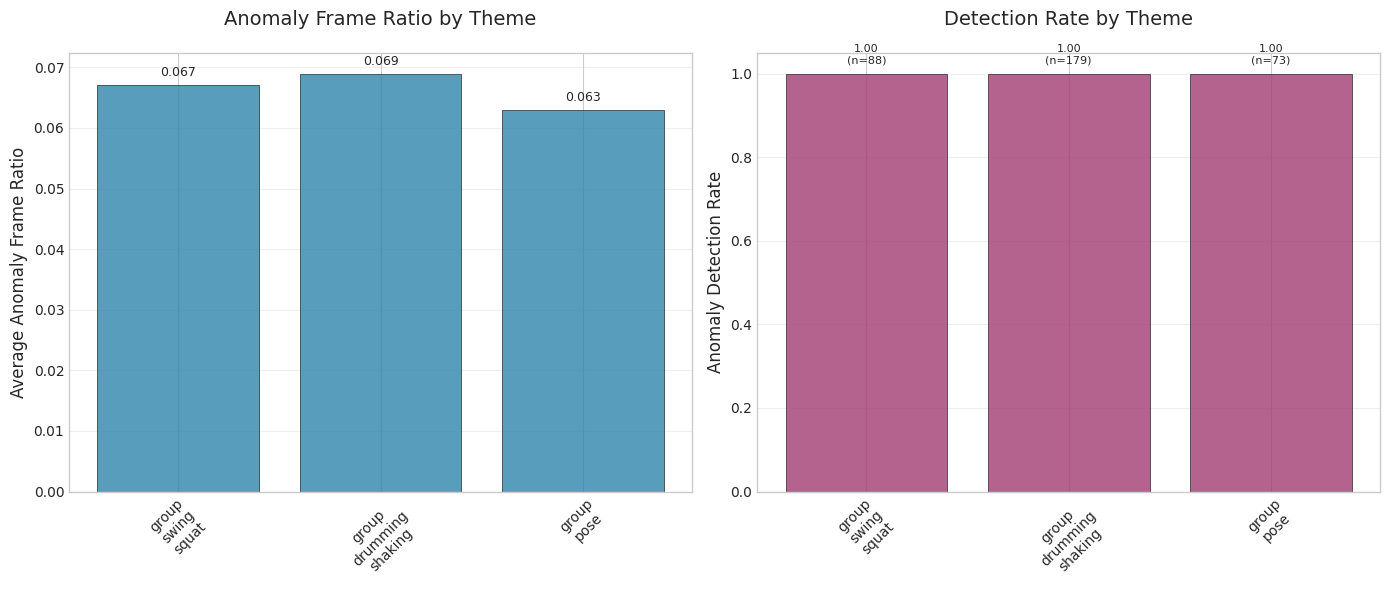

Theme指标对比图已保存并显示！


In [24]:
def plot_theme_metrics(all_data):
    """绘制各theme的异常帧比例和检测率对比"""
    # 筛选单独的theme（排除group）
    themes = [k for k in all_data.keys() if not k.startswith('group_')]
    if not themes:
        themes = list(all_data.keys())  # 备用：使用group
    
    # 提取指标
    theme_names = []
    anomaly_ratios = []
    detection_rates = []
    sequence_counts = []
    
    for theme in themes:
        df = all_data[theme]
        theme_names.append(theme.replace('_', '\n'))  # 换行显示长名称
        anomaly_ratios.append(df['anomaly_frame_ratio'].mean())
        detection_rates.append((df['pred_label'] == 1).sum() / len(df))
        sequence_counts.append(len(df))
    
    # 创建双子图
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # 子图1：异常帧比例
    bars1 = ax1.bar(theme_names, anomaly_ratios, color='#2E86AB', alpha=0.8, edgecolor='black', linewidth=0.5)
    ax1.set_ylabel('Average Anomaly Frame Ratio', fontsize=12)
    ax1.set_title('Anomaly Frame Ratio by Theme', fontsize=14, pad=20)
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3)
    
    # 添加数值标签
    for bar, ratio in zip(bars1, anomaly_ratios):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{ratio:.3f}', ha='center', va='bottom', fontsize=9)
    
    # 子图2：检测率
    bars2 = ax2.bar(theme_names, detection_rates, color='#A23B72', alpha=0.8, edgecolor='black', linewidth=0.5)
    ax2.set_ylabel('Anomaly Detection Rate', fontsize=12)
    ax2.set_title('Detection Rate by Theme', fontsize=14, pad=20)
    ax2.tick_params(axis='x', rotation=45)
    ax2.set_ylim(0, 1.05)
    ax2.grid(axis='y', alpha=0.3)
    
    # 添加数值标签和样本数
    for bar, rate, count in zip(bars2, detection_rates, sequence_counts):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{rate:.2f}\n(n={count})', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.savefig(os.path.join(VISUALIZATION_DIR, 'theme_metrics_comparison.png'), dpi=300, bbox_inches='tight')
    plt.show()  # 立即显示图表
    print("Theme指标对比图已保存并显示！")

# 执行绘图
plot_theme_metrics(all_data)

In [25]:
def plot_theme_radar(all_data):
    """绘制各theme的多维度指标雷达图"""
    # 筛选最多5个theme（避免图表拥挤）
    themes = [k for k in all_data.keys() if not k.startswith('group_')][:5]
    if len(themes) < 2:
        print("Theme数量不足，跳过雷达图绘制")
        return
    
    # 定义评估维度
    metrics = ['anomaly_ratio', 'detection_rate', 'avg_prob', 'seq_count_norm']
    metric_labels = ['Anomaly Frame Ratio', 'Detection Rate', 'Avg Anomaly Prob', 'Sequence Count']
    
    # 数据预处理（归一化）
    theme_data = {}
    max_vals = {m: 1 for m in metrics}  # 初始化最大值
    
    # 第一次遍历：计算最大值用于归一化
    for theme in themes:
        df = all_data[theme]
        data = {
            'anomaly_ratio': df['anomaly_frame_ratio'].mean(),
            'detection_rate': (df['pred_label'] == 1).sum() / len(df),
            'avg_prob': df['seq_anomaly_prob'].mean(),
            'seq_count_norm': len(df)  # 样本数量
        }
        theme_data[theme] = data
        
        # 更新最大值
        for m in metrics:
            if data[m] > max_vals[m]:
                max_vals[m] = data[m]
    
    # 第二次遍历：归一化数据
    for theme in themes:
        for m in metrics:
            if max_vals[m] > 0:
                theme_data[theme][m] /= max_vals[m]
    
    # 绘制雷达图
    angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]  # 闭合图形
    
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))
    
    # 配色方案
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
    
    for i, theme in enumerate(themes):
        values = [theme_data[theme][m] for m in metrics]
        values += values[:1]  # 闭合数据
        
        # 绘制雷达图
        ax.plot(angles, values, label=theme, color=colors[i], linewidth=2, marker='o', markersize=6)
        ax.fill(angles, values, color=colors[i], alpha=0.1)
    
    # 设置标签
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metric_labels, fontsize=11)
    ax.set_ylim(0, 1.0)
    ax.set_title('Multi-Dimension Metrics by Theme', fontsize=16, pad=30)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=10)
    
    # 添加网格
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(VISUALIZATION_DIR, 'theme_radar_chart.png'), dpi=300, bbox_inches='tight')
    plt.show()  # 立即显示图表
    print("Theme雷达图已保存并显示！")

# 执行绘图
plot_theme_radar(all_data)

Theme数量不足，跳过雷达图绘制


/tmp/ipykernel_39623/2257629277.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


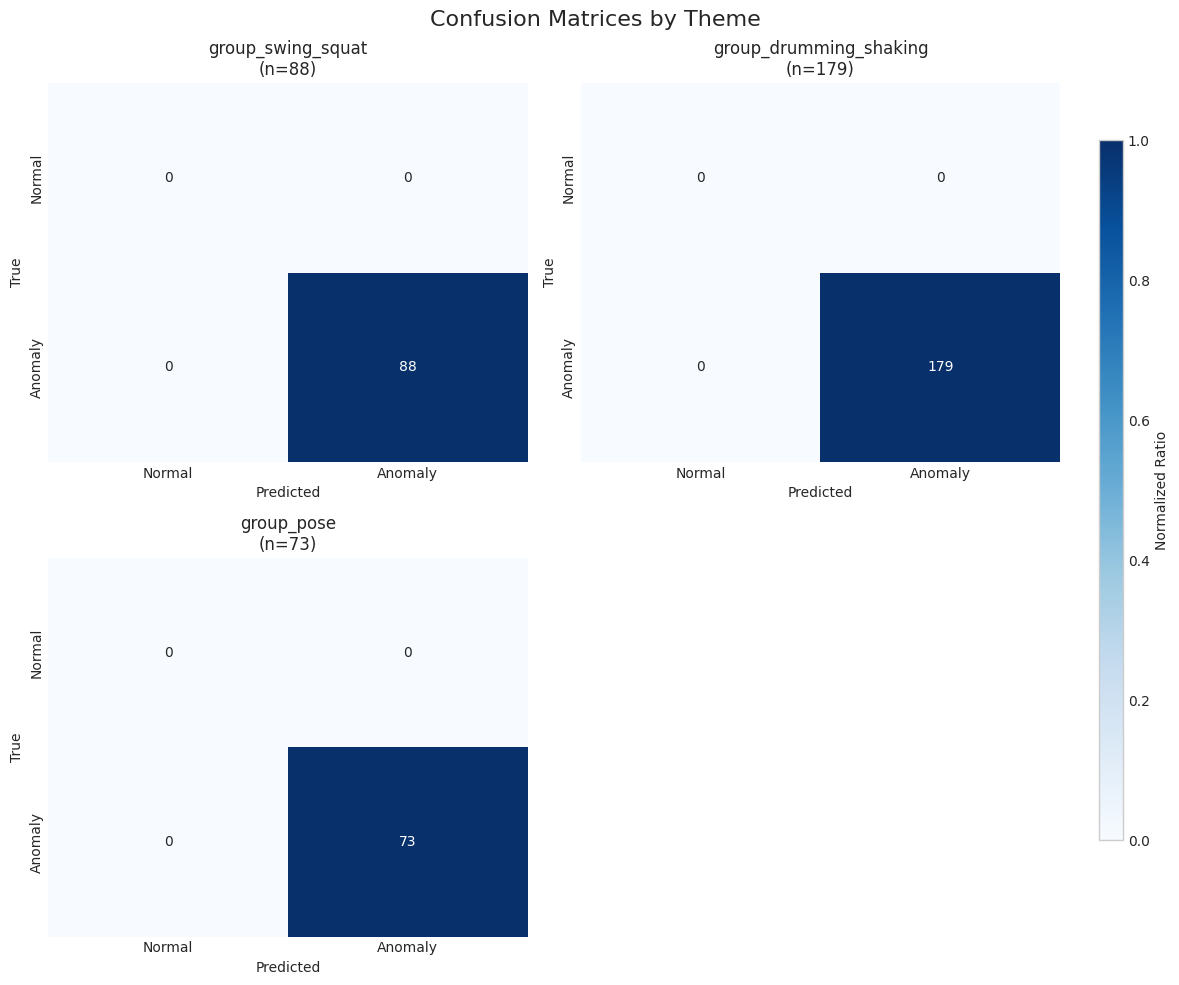

Theme混淆矩阵图已保存并显示！


In [28]:
def plot_theme_confusion_matrices(all_data):
    """绘制各theme的混淆矩阵（子图形式）"""
    themes = [k for k in all_data.keys() if not k.startswith('group_')][:4]  # 最多4个theme
    if not themes:
        themes = list(all_data.keys())[:4]
    
    num_themes = len(themes)
    cols = 2
    rows = (num_themes + 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))
    axes = axes.flatten()  # 扁平化处理
    
    # 遍历每个theme
    for i, theme in enumerate(themes):
        ax = axes[i]
        df = all_data[theme]
        
        # 计算混淆矩阵（指定labels避免警告）
        cm = confusion_matrix(df['true_label'], df['pred_label'], labels=[0, 1])
        # 安全归一化（避免除以零）
        cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-8)
        
        # 绘制热力图
        sns.heatmap(cm_norm, annot=cm, fmt='d', cmap='Blues', ax=ax,
                    xticklabels=['Normal', 'Anomaly'],
                    yticklabels=['Normal', 'Anomaly'],
                    annot_kws={"size": 10},
                    cbar=False,
                    vmin=0, vmax=1)
        
        ax.set_title(f'{theme}\n(n={len(df)})', fontsize=12)
        ax.set_xlabel('Predicted', fontsize=10)
        ax.set_ylabel('True', fontsize=10)
    
    # 隐藏多余的子图
    for i in range(num_themes, len(axes)):
        axes[i].axis('off')
    
    # 添加统一的颜色条
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    fig.colorbar(sm, cax=cbar_ax, label='Normalized Ratio')
    
    plt.suptitle('Confusion Matrices by Theme', fontsize=16, y=0.98)
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.savefig(os.path.join(VISUALIZATION_DIR, 'theme_confusion_matrices.png'), dpi=300, bbox_inches='tight')
    plt.show()  # 立即显示图表
    print("Theme混淆矩阵图已保存并显示！")

# 执行绘图
plot_theme_confusion_matrices(all_data)

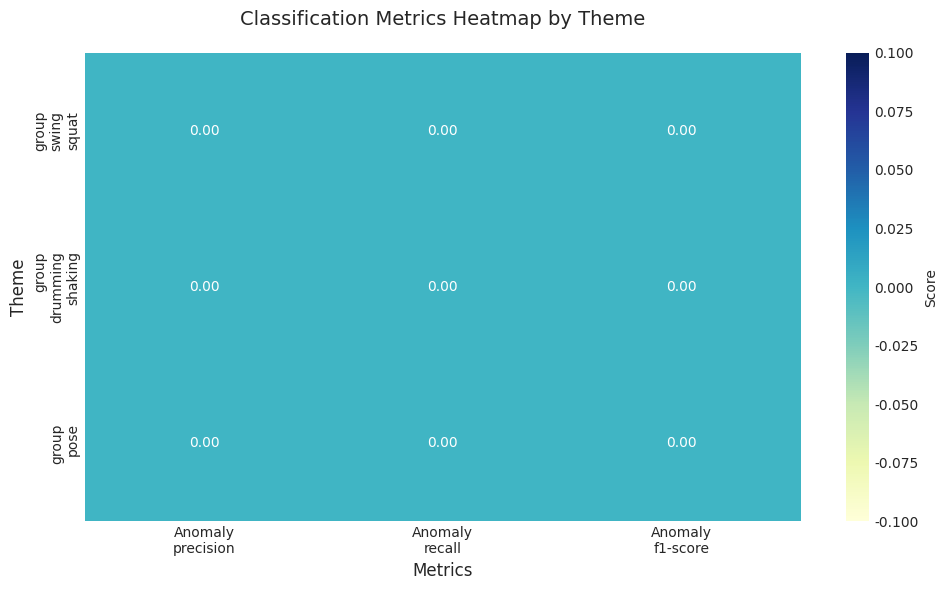

Theme分类报告热力图已保存并显示！


In [29]:
def plot_theme_classification_heatmap(all_data):
    """绘制各Theme分类报告热力图"""
    themes = [k for k in all_data.keys() if not k.startswith('group_')]
    if not themes:
        themes = list(all_data.keys())[:4]
    
    # 定义要展示的指标
    metrics = ['precision', 'recall', 'f1-score']
    classes = ['Anomaly']  # 仅展示异常类（正常类无样本）
    
    # 创建数据矩阵
    data = np.zeros((len(themes), len(metrics)*len(classes)))
    theme_labels = []
    
    for i, theme in enumerate(themes):
        df = all_data[theme]
        theme_labels.append(theme.replace('_', '\n'))
        
        # 生成分类报告
        report = classification_report(df['true_label'], df['pred_label'], 
                                       output_dict=True, zero_division=0)
        
        # 提取异常类指标
        j = 0
        for cls in classes:
            for m in metrics:
                if cls in report:
                    data[i, j] = report[cls][m]
                else:
                    data[i, j] = 0
                j += 1
    
    # 创建热力图标签
    heatmap_labels = [f'{cls}\n{m}' for cls in classes for m in metrics]
    
    # 绘制热力图
    fig, ax = plt.subplots(figsize=(10, max(6, len(themes)*1.5)))
    sns.heatmap(data, annot=True, fmt='.2f', cmap='YlGnBu', ax=ax,
                xticklabels=heatmap_labels,
                yticklabels=theme_labels,
                annot_kws={"size": 10},
                cbar_kws={'label': 'Score'})
    
    ax.set_title('Classification Metrics Heatmap by Theme', fontsize=14, pad=20)
    ax.set_xlabel('Metrics', fontsize=12)
    ax.set_ylabel('Theme', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(os.path.join(VISUALIZATION_DIR, 'theme_classification_heatmap.png'), dpi=300, bbox_inches='tight')
    plt.show()  # 立即显示图表
    print("Theme分类报告热力图已保存并显示！")

# 执行绘图
plot_theme_classification_heatmap(all_data)

/tmp/ipykernel_39623/116967895.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(box_data, labels=theme_labels, patch_artist=True,


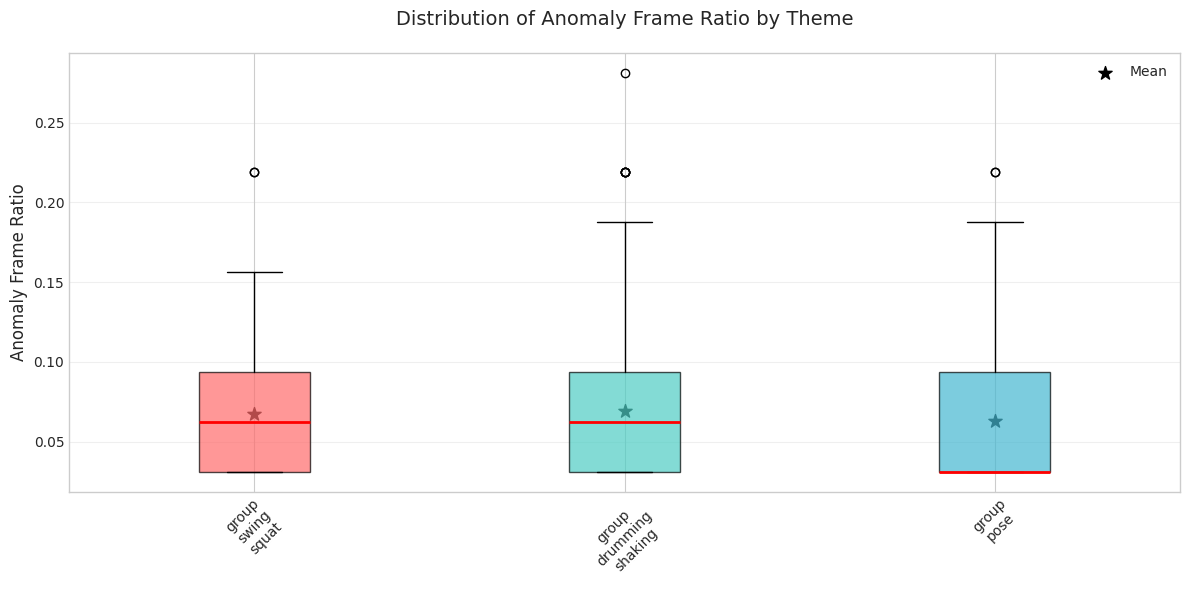

Theme箱线图已保存并显示！


In [30]:
def plot_theme_boxplot(all_data):
    """绘制各Theme异常帧比例的箱线图"""
    themes = [k for k in all_data.keys() if not k.startswith('group_')]
    if not themes:
        themes = list(all_data.keys())
    
    # 准备箱线图数据
    box_data = []
    theme_labels = []
    
    for theme in themes:
        df = all_data[theme]
        box_data.append(df['anomaly_frame_ratio'].values)
        theme_labels.append(theme.replace('_', '\n'))
    
    # 绘制箱线图
    fig, ax = plt.subplots(figsize=(12, 6))
    box = ax.boxplot(box_data, labels=theme_labels, patch_artist=True,
                     boxprops=dict(facecolor='#87CEEB', alpha=0.7),
                     medianprops=dict(color='red', linewidth=2),
                     whiskerprops=dict(color='black'),
                     capprops=dict(color='black'))
    
    # 为每个箱体设置不同颜色
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD']
    for patch, color in zip(box['boxes'], colors[:len(box['boxes'])]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_ylabel('Anomaly Frame Ratio', fontsize=12)
    ax.set_title('Distribution of Anomaly Frame Ratio by Theme', fontsize=14, pad=20)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)
    
    # 添加均值点
    means = [np.mean(data) for data in box_data]
    ax.scatter(range(1, len(means)+1), means, color='black', marker='*', s=100, label='Mean')
    ax.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(VISUALIZATION_DIR, 'theme_boxplot.png'), dpi=300, bbox_inches='tight')
    plt.show()  # 立即显示图表
    print("Theme箱线图已保存并显示！")

# 执行绘图
plot_theme_boxplot(all_data)

In [11]:
# %% 单元格7：详细可视化分析（多帧数+多模态对比，修复类别数不匹配问题）
def detailed_visualization_with_frames(log_data, label_names):
    """
    详细可视化分析（支持多帧数分组）：
    1. 各分组损失/准确率曲线对比
    2. 多模态+多帧数指标雷达图
    3. 混淆矩阵（按分组展示）
    4. 类别级准确率对比
    5. 分类报告热力图
    """
    # 修复字体问题：使用通用英文字体，避免中文依赖
    plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial', 'Helvetica', 'sans-serif']
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams['figure.figsize'] = (18, 12)  # 扩大图表尺寸，适配英文标签
    plt.rcParams['font.size'] = 11

    results_2d = log_data['2d']
    results_3d = log_data['3d']
    supported_frames = log_data['params']['supported_frames']
    epochs = log_data['params']['epochs']
    epochs_range = range(1, epochs + 1)

    # 颜色方案（兼容大小写）
    colors_modality = {'2d': '#2E86AB', '3d': '#A23B72', '2D': '#2E86AB', '3D': '#A23B72'}
    colors_frame = {32: '#F18F01', 64: '#C73E1D'}

    # ========== 图1：损失曲线对比（所有分组） ==========
    plt.subplot(2, 3, 1)
    for modality, results in [('2d', results_2d), ('3d', results_3d)]:
        for frame_num, res in results.items():
            train_loss = res['train_log']['loss']
            test_loss = res['test_log']['loss']
            label = f'{modality.upper()}-{frame_num}f'
            plt.plot(epochs_range, train_loss, label=f'{label}-Train', 
                     color=colors_modality[modality], linewidth=2, 
                     linestyle='-' if frame_num == 32 else '--')
            plt.plot(epochs_range, test_loss, label=f'{label}-Test', 
                     color=colors_modality[modality], linewidth=2, 
                     linestyle=':' if frame_num == 32 else '-.')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve Comparison (All Groups)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    plt.grid(alpha=0.3)
    plt.tight_layout()

    # ========== 图2：准确率曲线对比（所有分组） ==========
    plt.subplot(2, 3, 2)
    for modality, results in [('2d', results_2d), ('3d', results_3d)]:
        for frame_num, res in results.items():
            train_acc = res['train_log']['acc']
            test_acc = res['test_log']['acc']
            best_acc = res['best_metrics']['acc']
            best_epoch = res['best_metrics']['epoch']
            label = f'{modality.upper()}-{frame_num}f'
            # 绘制曲线
            plt.plot(epochs_range, train_acc, label=f'{label}-Train', 
                     color=colors_modality[modality], linewidth=2, 
                     linestyle='-' if frame_num == 32 else '--')
            plt.plot(epochs_range, test_acc, label=f'{label}-Test', 
                     color=colors_modality[modality], linewidth=2, 
                     linestyle=':' if frame_num == 32 else '-.')
            # 标注最佳准确率
            plt.scatter(best_epoch, best_acc, color=colors_modality[modality], s=50, zorder=5)
            plt.annotate(f'{best_acc:.3f}', 
                         xy=(best_epoch, best_acc), 
                         xytext=(best_epoch+1, best_acc-0.05),
                         color=colors_modality[modality], fontsize=8)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve Comparison (All Groups)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    plt.grid(alpha=0.3)
    plt.ylim(0, 1.05)
    plt.tight_layout()

    # ========== 图3：多指标雷达图（最佳分组对比） ==========
    plt.subplot(2, 3, 3)
    # 收集所有分组的最佳指标
    radar_data = []
    labels_radar = []
    for modality, results in [('2d', results_2d), ('3d', results_3d)]:
        for frame_num, res in results.items():
            metrics = [
                res['best_metrics']['acc'],
                res['best_metrics']['precision'],
                res['best_metrics']['recall'],
                res['best_metrics']['f1']
            ]
            radar_data.append(metrics)
            labels_radar.append(f'{modality.upper()}-{frame_num}f')
    
    # 雷达图设置（英文指标名）
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    angles = np.linspace(0, 2*np.pi, len(metrics_names), endpoint=False).tolist()
    angles += angles[:1]
    metrics_names += metrics_names[:1]

    # 绘制雷达图（修复标签格式）
    for i, (data, label) in enumerate(zip(radar_data, labels_radar)):
        data += data[:1]
        # 兼容标签格式（提取模态部分，转为小写）
        modality_part = label.split('-')[0].lower()
        color = colors_modality[modality_part]
        plt.polar(angles, data, label=label, color=color, linewidth=2, marker='o', markersize=3)
        plt.fill(angles, data, color=color, alpha=0.1)
    
    plt.xticks(angles[:-1], metrics_names[:-1], fontsize=10)
    plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ['0.2', '0.4', '0.6', '0.8', '1.0'], alpha=0.7)
    plt.ylim(0, 1.0)
    plt.title('Multi-Metric Radar Chart (All Groups)', pad=20)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=9)
    plt.tight_layout()

    # ========== 图4：混淆矩阵（最佳性能分组） ==========
    plt.subplot(2, 3, 4)
    # 找到最佳F1的分组
    best_f1 = 0.0
    best_conf = None
    best_label = ""
    best_res = None
    for modality, results in [('2d', results_2d), ('3d', results_3d)]:
        for frame_num, res in results.items():
            if res['best_metrics']['f1'] > best_f1:
                best_f1 = res['best_metrics']['f1']
                best_preds = res['best_metrics']['preds']
                best_true = res['best_metrics']['labels']
                # 获取该分组实际存在的类别ID（去重并排序）
                actual_class_ids = sorted(list(set(best_true) | set(best_preds)))
                best_conf = confusion_matrix(best_true, best_preds, labels=actual_class_ids)
                best_label = f'{modality.upper()}-{frame_num}f'
                best_res = res  # 保存最佳结果
    
    # 关键修复：按实际类别ID过滤target_names，确保一一对应
    actual_class_names = [label_names[class_id] for class_id in actual_class_ids]
    
    # 绘制最佳分组混淆矩阵
    cm_norm = best_conf.astype('float') / best_conf.sum(axis=1)[:, np.newaxis] * 100
    sns.heatmap(cm_norm, annot=best_conf, fmt='d', cmap='Blues',
                xticklabels=actual_class_names, yticklabels=actual_class_names,
                cbar_kws={'label': 'Accuracy (%)'},
                annot_kws={'fontsize': 9})
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix (Best Group: {best_label}, F1: {best_f1:.3f})')
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.yticks(rotation=0, fontsize=9)
    plt.tight_layout()

    # ========== 图5：类别级准确率对比（所有分组） ==========
    plt.subplot(2, 3, 5)
    x = np.arange(len(actual_class_names))  # 使用实际类别数
    width = 0.15  # 柱宽
    offset = -len(radar_data)*width/2  # 偏移量

    for i, (label, _) in enumerate(zip(labels_radar, radar_data)):
        # 解析分组信息（修复格式）
        modality_part = label.split('-')[0].lower()
        frame_num = int(label.split('-')[1][:-1])
        res = results_2d[frame_num] if modality_part == '2d' else results_3d[frame_num]
        group_preds = res['best_metrics']['preds']
        group_true = res['best_metrics']['labels']
        
        # 计算该分组的类别级准确率（仅包含实际存在的类别）
        class_acc = []
        for class_id in actual_class_ids:
            mask = group_true == class_id
            if mask.sum() > 0:
                acc = (group_preds[mask] == class_id).sum() / mask.sum()
            else:
                acc = 0.0
            class_acc.append(acc)
        
        # 绘制柱状图
        plt.bar(x + offset + i*width, class_acc, width, label=label, 
                color=colors_modality[modality_part], alpha=0.8)
        # 标注数值（只标注前3个分组，避免拥挤）
        if i < 3:
            for k, v in enumerate(class_acc):
                plt.text(x[k] + offset + i*width, v + 0.02, f'{v:.2f}', 
                         ha='center', va='bottom', fontsize=7)
    
    plt.xlabel('Class')
    plt.ylabel('Class Accuracy')
    plt.title('Class-Level Accuracy Comparison (All Groups)')
    plt.xticks(x, actual_class_names, rotation=45, ha='right', fontsize=9)
    plt.ylim(0, 1.1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    plt.grid(alpha=0.3, axis='y')
    plt.tight_layout()

    # ========== 图6：各分组核心指标汇总 ==========
    plt.subplot(2, 3, 6)
    # 收集核心指标
    frame_nums = []
    accs_2d = []
    accs_3d = []
    for frame_num in supported_frames:
        frame_nums.append(f'{frame_num}f')  # 简化标签为"32f"/"64f"
        accs_2d.append(results_2d[frame_num]['best_metrics']['acc'] if frame_num in results_2d else 0)
        accs_3d.append(results_3d[frame_num]['best_metrics']['acc'] if frame_num in results_3d else 0)
    
    # 绘制分组对比柱状图
    x = np.arange(len(frame_nums))
    width = 0.35
    plt.bar(x - width/2, accs_2d, width, label='2D Modality', color=colors_modality['2d'], alpha=0.8)
    plt.bar(x + width/2, accs_3d, width, label='3D Modality', color=colors_modality['3d'], alpha=0.8)
    # 标注数值
    for i, v in enumerate(accs_2d):
        if v > 0:
            plt.text(i - width/2, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=10)
    for i, v in enumerate(accs_3d):
        if v > 0:
            plt.text(i + width/2, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=10)
    plt.xlabel('Frame Number')
    plt.ylabel('Best Accuracy')
    plt.title('Accuracy Comparison (Modality x Frames)')
    plt.xticks(x, frame_nums, fontsize=10)
    plt.ylim(0, 1.1)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3, axis='y')
    plt.tight_layout()

    # 保存综合图表
    plt.savefig('comprehensive_visualization_with_frames.png', dpi=300, bbox_inches='tight')
    plt.show()

    # ========== 额外：分类报告热力图（最佳分组） ==========
    plt.figure(figsize=(12, 6))
    # 最佳分组分类报告（使用实际类别ID和类别名）
    best_preds = best_res['best_metrics']['preds']
    best_true = best_res['best_metrics']['labels']
    
    # 生成分类报告（指定labels参数，确保与target_names匹配）
    report = classification_report(
        best_true, best_preds, 
        labels=actual_class_ids,  # 关键：指定实际存在的类别ID
        target_names=actual_class_names,  # 过滤后的类别名
        output_dict=True,
        zero_division=0  # 避免除以零警告
    )
    report_df = pd.DataFrame(report).T[:-3]  # 去除avg和total行
    report_df = report_df[['precision', 'recall', 'f1-score']]

    # 绘制热力图
    sns.heatmap(report_df, annot=True, cmap='Blues', vmin=0, vmax=1, fmt='.3f',
                annot_kws={'fontsize': 10},
                cbar_kws={'label': 'Score'})
    plt.title(f'Classification Report (Best Group: {best_label}, F1: {best_f1:.3f})', fontsize=12)
    plt.xlabel('Metrics', fontsize=11)
    plt.ylabel('Classes', fontsize=11)
    plt.xticks(rotation=0, fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.savefig('best_group_classification_report.png', dpi=300, bbox_inches='tight')
    plt.show()

    # ========== 输出详细文字报告 ==========
    print("\n" + "="*80)
    print("📋 Detailed Performance Comparison Report (Modality x Frames)")
    print("="*80)
    print(f"{'Group':<12} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Sample Size':<10}")
    print("-"*80)
    for modality, results in [('2d', results_2d), ('3d', results_3d)]:
        for frame_num, res in results.items():
            group_name = f'{modality.upper()}-{frame_num}f'
            acc = res['best_metrics']['acc']
            prec = res['best_metrics']['precision']
            rec = res['best_metrics']['recall']
            f1 = res['best_metrics']['f1']
            sample_num = res['train_samples'] + res['test_samples']
            print(f"{group_name:<12} {acc:.4f}     {prec:.4f}     {rec:.4f}     {f1:.4f}     {sample_num:<10}")

    print(f"\n🏆 Best Group: {best_label}")
    print(f"  Best F1-Score: {best_f1:.4f}")
    print(f"  Best Accuracy: {best_res['best_metrics']['acc']:.4f}")
    print(f"  Actual Classes: {actual_class_names}")  # 显示实际训练的类别
    print(f"  Corresponding Model Path: {best_res['model_path']}")

    print(f"\n📁 Generated Visualization Files:")
    print(f"  1. comprehensive_visualization_with_frames.png (Comprehensive Comparison)")
    print(f"  2. best_group_classification_report.png (Best Group Classification Report)")
    print("="*80)

# 加载训练日志并执行可视化
with open('training_logs_with_frames.pkl', 'rb') as f:
    log_data = pickle.load(f)

detailed_visualization_with_frames(log_data, label_names=dataset_2d.label_names)

NameError: name 'dataset_2d' is not defined